In [96]:
from pathlib import Path
pdf_file = Path("..\\data\\article_pdf\\1706.03762.pdf")
assert pdf_file.is_file()

file_name = "https://arxiv.org/pdf/2201.04234"

In [ ]:
import os
from mistralai import Mistral

api_key = 'vya1TxPJKsBtZrAidZ66Udt7gyFfsSgs'
client = Mistral(api_key=api_key)

ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": file_name
    },
    include_image_base64=True
)

In [19]:
import json

def serialize(obj):
    return obj.__dict__ if hasattr(obj, '__dict__') else str(obj)

# Convert to JSON with a custom serializer
ocr_json = json.dumps(ocr_response, default=serialize, indent=4)

# Save to a file
with open("output.json", "w") as file:
    file.write(ocr_json)


In [33]:
with open('output.json', 'r') as file:
    data = json.load(file)

# Extract images
images = [y['image_base64'] for x in data["pages"] if  x.get('images') for y in x['images']]

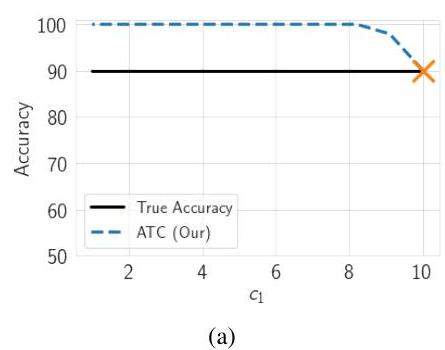

In [41]:
from IPython.display import Image, display
import base64


# Base64 string of the image (example)
image_base64 = images[4]


# If there's a header, remove it
if image_base64.startswith("data:image"):
    image_base64 = image_base64.split(",")[1]

# Decode and display
try:
    display(Image(data=base64.b64decode(image_base64)))
except Exception as e:
    print(f"Failed to display image: {e}")# Display the image

## Marckdown to Semantic

In [45]:
md = [x['markdown'] for x in data['pages']]
md[0]

"# LEVERAGING UNLABELED DATA TO PREDICT OUT-OF-DISTRIBUTION PERFORMANCE \n\nSaurabh Garg*<br>Carnegie Mellon University<br>sgarg2@andrew.cmu.edu<br>Sivaraman Balakrishnan<br>Carnegie Mellon University<br>sbalakri@andrew.cmu.edu<br>Zachary C. Lipton<br>Carnegie Mellon University<br>zlipton@andrew.cmu.edu\n\n## Behnam Neyshabur\n\nGoogle Research, Blueshift team\nneyshabur@google.com\n\nHanie Sedghi<br>Google Research, Brain team<br>hsedghi@google.com\n\n\n#### Abstract\n\nReal-world machine learning deployments are characterized by mismatches between the source (training) and target (test) distributions that may cause performance drops. In this work, we investigate methods for predicting the target domain accuracy using only labeled source data and unlabeled target data. We propose Average Thresholded Confidence (ATC), a practical method that learns a threshold on the model's confidence, predicting accuracy as the fraction of unlabeled examples for which model confidence exceeds that th

In [52]:
import re
import json

class MarkdownToJsonConverter:
    def __init__(self, markdown_text):
        self.text = markdown_text
        self.json_data = {
            "title": None,
            "headers": [],
            "paragraphs": [],
            "lists": [],
            "links": [],
            "images": [],
            "tables": [],
            "code_blocks": [],
            "blockquotes": []
        }

    def parse_headers(self):
        headers = re.findall(r"^(#{1,6})\s+(.*)", self.text, re.MULTILINE)
        for header in headers:
            self.json_data["headers"].append({
                "level": len(header[0]),
                "text": header[1]
            })
        if headers and len(headers[0][0]) == 1:
            self.json_data["title"] = headers[0][1]

    def parse_paragraphs(self):
        paragraphs = re.split(r"\n\n+", self.text)
        for para in paragraphs:
            if not para.startswith("#") and not para.startswith("-") and not re.search(r"\[(.*?)\]\((.*?)\)", para):
                self.json_data["paragraphs"].append(para.strip())

    def parse_lists(self):
        lists = re.findall(r"(?m)^[-*+]\s+(.*)", self.text)
        if lists:
            self.json_data["lists"].append(lists)

    def parse_links(self):
        links = re.findall(r"\[(.*?)\]\((.*?)\)", self.text)
        for link in links:
            self.json_data["links"].append({
                "text": link[0],
                "url": link[1]
            })

    def parse_images(self):
        images = re.findall(r"!\[(.*?)\]\((.*?)\)", self.text)
        for image in images:
            self.json_data["images"].append({
                "alt_text": image[0],
                "url": image[1]
            })

    def parse_tables(self):
        tables = re.findall(r"(?:\|.+?\|\n)+", self.text)
        for table in tables:
            rows = [row.strip().split("|")[1:-1] for row in table.split("\n") if row.startswith("|")]
            if rows:
                headers = rows[0]
                data_rows = rows[1:]
                self.json_data["tables"].append({
                    "headers": headers,
                    "rows": data_rows
                })

    def parse_code_blocks(self):
        code_blocks = re.findall(r"```(.*?)\n(.*?)```", self.text, re.S)
        for block in code_blocks:
            self.json_data["code_blocks"].append({
                "language": block[0].strip(),
                "code": block[1].strip()
            })

    def parse_blockquotes(self):
        blockquotes = re.findall(r"^>\s+(.*)", self.text, re.MULTILINE)
        for quote in blockquotes:
            self.json_data["blockquotes"].append(quote.strip())

    def convert(self):
        self.parse_headers()
        self.parse_paragraphs()
        self.parse_lists()
        self.parse_links()
        self.parse_images()
        self.parse_tables()
        self.parse_code_blocks()
        self.parse_blockquotes()
        return json.dumps(self.json_data, indent=4)

# Example usage:
converter = MarkdownToJsonConverter(md[6])
print(converter.convert())

{
    "title": null,
    "headers": [
        {
            "level": 3,
            "text": "5.1 RESULTS"
        }
    ],
    "paragraphs": [
        "| Dataset | Shift | IM |  | AC |  | DOC |  | GDE | ATC-MC (Ours) |  | ATC-NE (Ours) |  |\n| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |\n|  |  | Pre T | Post T | Pre T | Post T | Pre T | Post T | Post T | Pre T | Post T | Pre T | Post T |\n| CIFAR10 | Natural | 6.60 | 5.74 | 9.88 | 6.89 | 7.25 | 6.07 | 4.77 | 3.21 | 3.02 | 2.99 | 2.85 |\n|  | Synthetic | 12.33 | 10.20 | 16.50 | 11.91 | 13.87 | 11.08 | 6.55 | 4.65 | 4.25 | 4.21 | 3.87 |\n| CIFAR100 | Synthetic | 13.69 | 11.51 | 23.61 | 13.10 | 14.60 | 10.14 | 9.85 | 5.50 | 4.75 | 4.72 | 4.94 |\n| ImageNet200 | Natural | 12.37 | 8.19 | 22.07 | 8.61 | 15.17 | 7.81 | 5.13 | 4.37 | 2.04 | 3.79 | 1.45 |\n|  | Synthetic | 19.86 | 12.94 | 32.44 | 13.35 | 25.02 | 12.38 | 5.41 | 5.93 | 3.09 | 5.00 | 2.68 |\n| ImageNet | Natural | 7.77 | 6.50 | 18.13 

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G):
    # Visualize the graph using matplotlib
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    plt.figure(figsize=(10, 10))  # Increase figure size for better visualization
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
    plt.title("Markdown Structure Visualization")
    plt.show()

In [ ]:
import re
import networkx as nx

class MarkdownParser:
    def __init__(self, markdown_text):
        self.text = markdown_text
        self.graph = nx.DiGraph()  # Directed graph to show hierarchy and relationships
        self.current_node = None
        self.json_data = {
            "title": None,
            "headers": [],
            "paragraphs": [],
            "lists": [],
            "links": [],
            "images": [],
            "tables": [],
            "code_blocks": [],
            "blockquotes": []
        }

    # Add node to the graph and JSON structure
    def add_node(self, node_type, content, parent=None):
        node_id = f"{node_type}_{len(self.graph.nodes)}"
        self.graph.add_node(node_id, type=node_type, content=content)
        if parent:
            self.graph.add_edge(parent, node_id)
        # Add to JSON structure as well
        if node_type == "Page":
            self.json_data["title"] = content.get("title")
        elif node_type.startswith("Header"):
            self.json_data["headers"].append(content)
        elif node_type == "List":
            self.json_data["lists"].append(content)
        elif node_type == "Link":
            self.json_data["links"].append(content)
        elif node_type == "Image":
            self.json_data["images"].append(content)
        elif node_type == "CodeBlock":
            self.json_data["code_blocks"].append(content)
        elif node_type == "Blockquote":
            self.json_data["blockquotes"].append(content)
        return node_id

    def parse_headers(self):
        headers = re.findall(r"^(#{1,6})\s+(.*)", self.text, re.MULTILINE)
        for header in headers:
            level = len(header[0])
            node_id = self.add_node(f"Header-{level}", {"text": header[1]}, self.current_node)
            self.current_node = node_id  # Update current node to this header
            
            self.json_data["headers"].append({
                "level": len(header[0]),
                "text": header[1]
            })
            
        if headers and len(headers[0][0]) == 1:
            self.json_data["title"] = headers[0][1]

    def parse_lists(self):
        lists = re.findall(r"(?m)^[-*+]\s+(.*)", self.text)
        if lists:
            list_node_id = self.add_node("List", {"items": lists}, self.current_node)
            for item in lists:
                self.add_node("ListItem", {"text": item}, list_node_id)

    def parse_links(self):
        links = re.findall(r"\[(.*?)\]\((.*?)\)", self.text)
        for link in links:
            self.add_node("Link", {"text": link[0], "url": link[1]}, self.current_node)

    def parse_images(self):
        images = re.findall(r"!\[(.*?)\]\((.*?)\)", self.text)
        for image in images:
            self.add_node("Image", {"alt_text": image[0], "url": image[1]}, self.current_node)

    def parse_blockquotes(self):
        blockquotes = re.findall(r"^>\s+(.*)", self.text, re.MULTILINE)
        for quote in blockquotes:
            self.add_node("Blockquote", {"text": quote}, self.current_node)

    def parse_code_blocks(self):
        code_blocks = re.findall(r"```(.*?)\n(.*?)```", self.text, re.S)
        for block in code_blocks:
            self.add_node("CodeBlock", {"language": block[0].strip(), "code": block[1].strip()}, self.current_node)

    def parse(self):
        self.add_node("Page", {"title": "Markdown Document"})  # Root node representing the page
        self.parse_headers()
        self.parse_lists()
        self.parse_links()
        self.parse_images()
        self.parse_blockquotes()
        self.parse_code_blocks()
        return self.graph

    def get_json(self):
        return json.dumps(self.json_data, indent=4)


# Example usage:

converter = MarkdownParser(md[6])
g = converter.parse()
visualize_graph(g)


In [124]:
import re
import networkx as nx
from pyvis.network import Network

class MarkdownGraph:
    def __init__(self, pages, file_name):
        """Initialize with a list of pages."""
        self.pages = pages
        self.graph = nx.Graph()
        self.document_node = file_name
        self.graph.add_node(self.document_node, type="Document", name='file_name', content="")

        self.headers_count = 0 
        self.title_count = 0

        self.parse_pages()


    def parse_pages(self):
        """Parse the pages and create nodes for document, pages, and entities."""
        # Iterate through each page
        for page_idx, self.page_text in enumerate(self.pages, start=1):

            self.page_node = f"page_{page_idx}"
            self.graph.add_node(self.page_node, type="Page", content="")
            self.graph.add_edge(self.document_node, self.page_node)  # Connect each page to the document


            self.parse_headers()
            self.parse_paragraphs()

            if page_idx > 2:
                break

    def parse_headers(self):
        headers = re.findall(r"^(#{1,6})\s+(.*)", self.page_text, re.MULTILINE)
        for header in headers:

            hi = self.headers_count
            header_node = f"title_{hi}"
            self.graph.add_node(
                header_node, 
                type="Header", 
                content=header[1], 
                level=len(header[0])
            )
            self.graph.add_edge(self.page_node, header_node)
            self.headers_count += 1

        if headers and len(headers[0][0]) == 1:
            ti = self.title_count
            title_node = f"title_{ti}"
            self.graph.add_node(
                title_node, 
                type="Title", 
                content=headers[0][1], 
            )
            self.graph.add_edge(self.page_node, title_node)
            self.title_count += 1

    def parse_paragraphs(self):
        sections = re.findall(r"(#{1,6})\s*([^\n]+)\s*([\s\S]*?)(?=\1\s*[^\n]+|\Z)", self.page_text)
        for header, name, content in sections:
            print(f"Header: {header} {name}\nContent:\n{content}\n")
        paragraphs = re.split(r"(#{1,6})\s*Header1\s*([\s\S]*?)\1\s*Header2", self.page_text)
        for pi, para in enumerate(paragraphs):
            if not para.startswith("#") and not para.startswith("-") and not re.search(r"\[(.*?)\]\((.*?)\)", para):

                paragraph_node = f"paragraph_{pi}"
                self.graph.add_node(
                    paragraph_node, 
                    type="Paragraph", 
                    content=para.strip(), 
                )
                self.graph.add_edge(self.page_node, paragraph_node)


    def parse_pages_off(self):
        """Parse the pages and create nodes for document, pages, and entities."""
        # Iterate through each page
        for page_idx, page_text in enumerate(self.pages, start=1):
            page_node = f"Page {page_idx}"
            self.graph.add_node(page_node, type="Page", content=f"")
            self.graph.add_edge(self.document_node, page_node)  # Connect each page to the document

            # Regular expressions for detecting title, subtitle, paragraphs, figures, and tables
            title_pattern = r"^# (.*)"  # Match the title (first line starting with '#')
            subtitle_pattern = r"^## (.*)"  # Match subtitles (lines starting with '##')
            paragraph_pattern = r"([^\n]+)\n"  # Match paragraphs (non-empty lines)
            figure_pattern = r"!\[.*\]\((.*\.jpg|.*\.png|.*\.jpeg|.*\.pdf)\)"  # Detect image references (figures)
            table_pattern = r"(Table \d+)"  # Detect table references

            # Detect the title, subtitle, and paragraphs for this page
            title = re.search(title_pattern, page_text)
            subtitles = re.findall(subtitle_pattern, page_text)
            paragraphs = re.findall(paragraph_pattern, page_text)
            figures = re.findall(figure_pattern, page_text)
            tables = re.findall(table_pattern, page_text)

            # Add the title as a node and connect it to the page
            if title:
                title_node = f"Title {page_idx}"
                self.graph.add_node(title_node, type="Title", content=title.group(1))
                self.graph.add_edge(page_node, title_node)

            # Add subtitles as nodes and connect them to the page
            for i, subtitle in enumerate(subtitles, start=1):
                subtitle_node = f"Subtitle {page_idx}-{i}"
                self.graph.add_node(subtitle_node, type="Subtitle", content=subtitle)
                self.graph.add_edge(page_node, subtitle_node)

            # Add nodes for paragraphs and connect them to the page
            self.add_paragraphs_and_references(page_node, paragraphs)

            # Add figures and tables as nodes and connect them to the page and paragraphs
            self.add_figures_and_tables(page_node, figures, tables)
            if page_idx >3:

                break

    def add_paragraphs_and_references(self, page_node, paragraphs):
        """Add paragraph nodes and connect them to the page."""
        for i, paragraph in enumerate(paragraphs, start=1):
            paragraph_node = f"Paragraph {page_node}-{i}"
            self.graph.add_node(paragraph_node, type="Paragraph", content=paragraph)
            self.graph.add_edge(page_node, paragraph_node)  # Connect paragraph to the page
            
            # Check if the paragraph references any figures or tables (this will be handled by add_figures_and_tables)

    def add_figures_and_tables(self, page_node, figures, tables):
        """Add figure and table nodes and connect them to the page and paragraphs."""
        for i, figure in enumerate(figures, start=1):
            figure_node = f"Figure {page_node}-{i}"
            self.graph.add_node(figure_node, type="Figure", content=figure)
            self.graph.add_edge(page_node, figure_node)  # Connect figure to the page
            
            # Find which paragraph references the figure and connect them
            for j, paragraph in enumerate(self.pages, start=1):
                if f"Figure {i}" in paragraph:
                    self.graph.add_edge(f"Paragraph {page_node}-{j}", figure_node)

        for i, table in enumerate(tables, start=1):
            table_node = f"Table {page_node}-{i}"
            self.graph.add_node(table_node, type="Table", content=table)
            self.graph.add_edge(page_node, table_node)  # Connect table to the page
            
            # Find which paragraph references the table and connect them
            for j, paragraph in enumerate(self.pages, start=1):
                if f"Table {i}" in paragraph:
                    self.graph.add_edge(f"Paragraph {page_node}-{j}", table_node)

    def visualize(self, output_filename="document_graph.html"):
        """Generate and save an interactive graph using Pyvis."""
        # Initialize the Pyvis network object
        net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black")
        
        # Convert the networkx graph to a Pyvis graph
        net.from_nx(self.graph)

        for node in self.graph.nodes:
            content = self.graph.nodes[node]['content']
            
            if content:
                net.get_node(node)['label'] = content

        net.save_graph(output_filename)
        
        print(f"Interactive graph saved as {output_filename}. Open this file in your browser for an explorable visualization.")


markdown_text = md
graph_creator = MarkdownGraph(markdown_text, file_name)
graph_creator.visualize(output_filename="document_graph.html")

Header: # LEVERAGING UNLABELED DATA TO PREDICT OUT-OF-DISTRIBUTION PERFORMANCE 
Content:
Saurabh Garg*<br>Carnegie Mellon University<br>sgarg2@andrew.cmu.edu<br>Sivaraman Balakrishnan<br>Carnegie Mellon University<br>sbalakri@andrew.cmu.edu<br>Zachary C. Lipton<br>Carnegie Mellon University<br>zlipton@andrew.cmu.edu



Header: ## Behnam Neyshabur
Content:
Google Research, Blueshift team
neyshabur@google.com

Hanie Sedghi<br>Google Research, Brain team<br>hsedghi@google.com




Header: #### Abstract
Content:
Real-world machine learning deployments are characterized by mismatches between the source (training) and target (test) distributions that may cause performance drops. In this work, we investigate methods for predicting the target domain accuracy using only labeled source data and unlabeled target data. We propose Average Thresholded Confidence (ATC), a practical method that learns a threshold on the model's confidence, predicting accuracy as the fraction of unlabeled examples for w